# Prediction of Number of Taxi Orders for Following Hour

The goal of this project was to use historical taxi orders to airports to train a model that predicts the number of taxis that will be ordered to airports in the following hour.

The dataset contains only the number of taxis ordered with datetime information as its index. The project was approached in a variety of ways: rolling averages, exponential smoothing, SARIMA analysis, and training machine learning models using 24-hour lag data. The final approach was the most successful, and in choosing and evaluating the specific model, RMSE was used as the metric.


*Note: As with some other projects, code that took a long time to run was commented to save time when working on and editing the project, and necessary information that otherwise would be printed was copied and pasted into Markdown cells.*



<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#### Импорты

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, train_test_split

from itertools import product

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

import optuna

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')



#### Загрузка и просмотр данных

In [3]:
try:
    taxi = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
taxi.sort_index(inplace=True)
taxi.info()
display(taxi.head())
display(taxi.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные в очень хорошей форме. Нету пропусков вообще, а при загрузке таблице сразу был поставлен правильный индекс datetime. 

## Подготовка

Нужно применить ресэмплинг чтобы организовать данные по часу вместо 10-минутных промежутков времени.

In [5]:
taxi = taxi.resample('1H').sum()

##### Подготовка к визуализации данных

Создам скользящие средние используя разные количества периодов (окна времени) чтобы визуализировать данные.

Потом, применим ээкспоненциальное сглаживание, ещё раз чтобы лучше визуализировать и понимать данные.

*Создание столбцов с скользящими средними (окна: 12 часов, 6 часов, 3 часов)*

In [6]:
taxi['rolling_mean_12h'] = taxi['num_orders'].rolling(12).mean()
taxi['rolling_std_12h'] = taxi['num_orders'].rolling(12).std()

taxi['rolling_mean_6h'] = taxi['num_orders'].rolling(6).mean()
taxi['rolling_std_6h'] = taxi['num_orders'].rolling(6).std()

taxi['rolling_mean_3h'] = taxi['num_orders'].rolling(3).mean()
taxi['rolling_std_3h'] = taxi['num_orders'].rolling(3).std()

*Замечание:* Я нашёл, что есть такой класс statsmodels.tsa.holtwinters.ExponentialSmoothing, но я решил писать свои функции для этого чтобы лучше понимать, как работает экспоненциальное сглаживание.

In [7]:
def single_exp_smooth(data, alpha):
    '''
    Применяет экспоненциальное сглаживание.
    Возвращает список с полученными ("сглаженными") значениями.
    
     alpha:
         - коэффициент сглаживания
         - float между 0 и 1
               - чем меньше значение, тем более сглаженной будет линия
     result: сглаженный ряд, инициолизирован с первым значением в 'num_orders'
    '''
    result = [data[0]]
    for i in range(1, len(data)):
        result.append(alpha * data[i] + (1-alpha) * result[i-1])
    return result

def double_exp_smooth(data, alpha, beta):
    '''
    Применяет двойное экспоненциальное сглаживание.
    Возвращает список с полученными ("сглаженными") значениями.
    
    alpha:
         - коэффициент сглаживания
         - float между 0 и 1
               - чем меньше значение, тем более сглаженной будет линия
     beta:
         - коэффициент сглаживания тренда
         - float между 0 и 1
               - чем меньше значение, тем более сглаженной будет линия
     result:
         - сглаженный ряд, инициолизирован с первым значением в 'num_orders'
     level:
         - значение, полученное от экспоненциального сглаживания (первой степени)
         - инициолизировано с настоящим первым значением данных
     trend:
         - предположение о тренде в данных, используя
         - инициолизировано как разность временного ряда (подобно data-data.shift())
    '''

    result = [data[0]]
    for i in range(1, len(data)):
        if i == 1:
            level, trend = data[0], data[1]-data[0]
        last, level = level, alpha * data[i] + (1-alpha) * (level + trend)
        trend = beta * (level - last) + (1 - beta)*trend
        result.append(level+trend)
    return result
            

*Применение экспоненциального сглаживания и добавление соответствующих столбцов.*

In [8]:
taxi['single_exp_0.2'] = single_exp_smooth(taxi['num_orders'], 0.2)
taxi['single_exp_0.5'] = single_exp_smooth(taxi['num_orders'], 0.5)
taxi['single_exp_0.7'] = single_exp_smooth(taxi['num_orders'], 0.7)

taxi['double_exp_a0.2_b0.2'] = double_exp_smooth(taxi['num_orders'], 0.2, 0.2)
taxi['double_exp_a0.2_b0.7'] = double_exp_smooth(taxi['num_orders'], 0.2, 0.7)
taxi['double_exp_a0.7_b0.2'] = double_exp_smooth(taxi['num_orders'], 0.7, 0.2)
taxi['double_exp_a0.7_b0.7'] = double_exp_smooth(taxi['num_orders'], 0.7, 0.7)


## Анализ

*Графики с исходными данными*

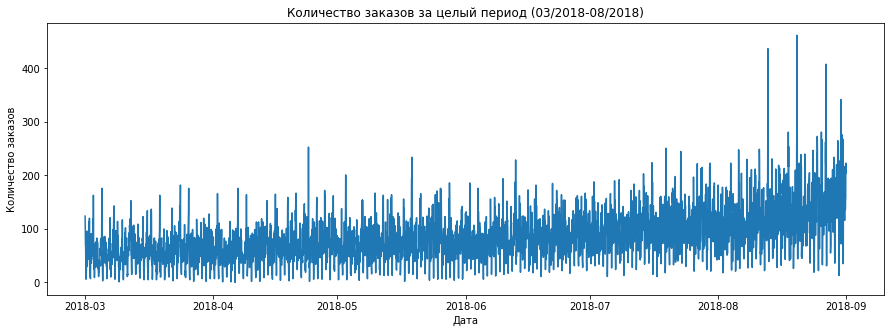

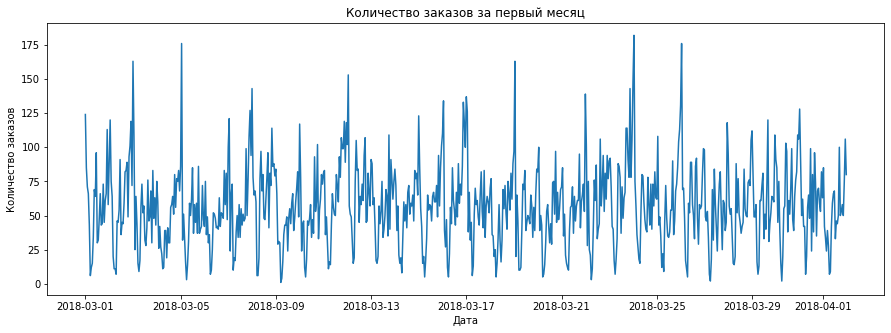

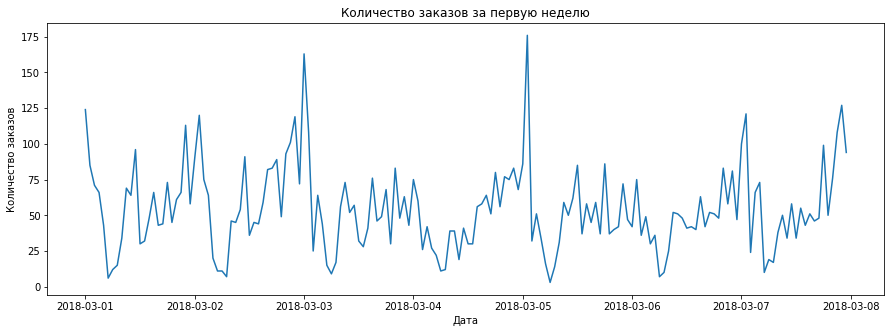

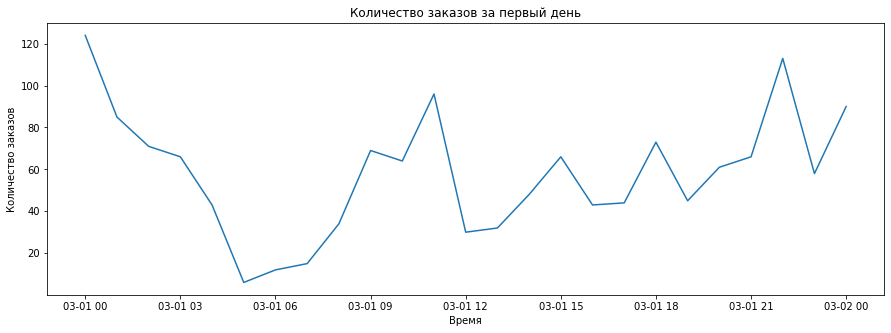

In [9]:
#Целый период

plt.figure(figsize=(15, 5))
plt.plot(taxi['num_orders'])
plt.title('Количество заказов за целый период (03/2018-08/2018)')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

#Один месяц
plt.figure(figsize=(15, 5))
plt.plot(taxi['2018-03-01':'2018-04-01']['num_orders'])
plt.title('Количество заказов за первый месяц')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

#Одна неделя
plt.figure(figsize=(15, 5))
plt.plot(taxi['2018-03-01':'2018-03-07']['num_orders'])
plt.title('Количество заказов за первую неделю')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

#Один день
plt.figure(figsize=(15, 5))
plt.plot(taxi['2018-03-01 00:00:00':'2018-03-02 00:00:00']['num_orders'])
plt.title('Количество заказов за первый день')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.show()


*Графики с скользящими средними*

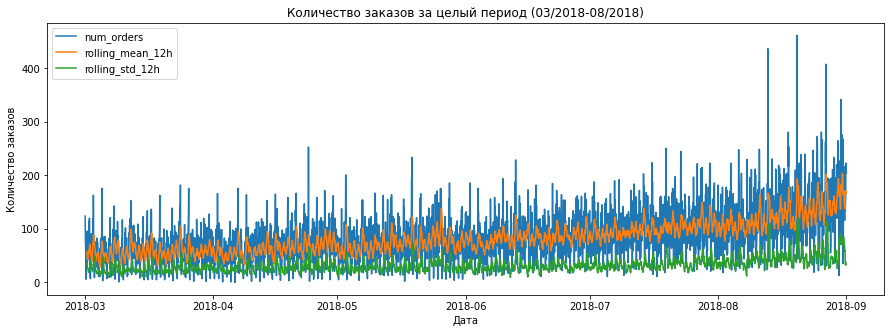

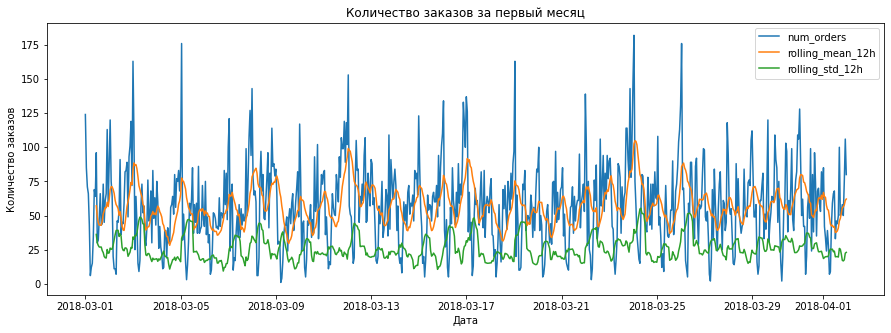

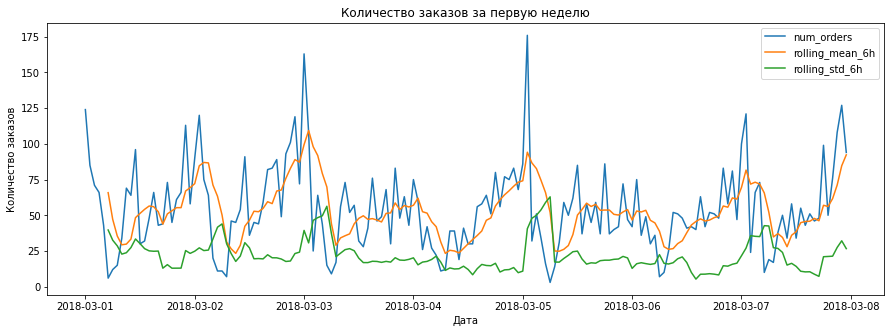

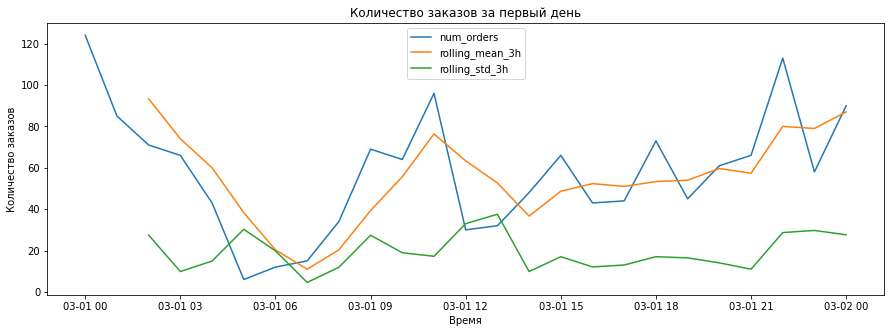

In [10]:
#Целый период

plt.figure(figsize=(15, 5))
plt.plot(taxi[['num_orders', 'rolling_mean_12h', 'rolling_std_12h']])
plt.title('Количество заказов за целый период (03/2018-08/2018)')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'rolling_mean_12h', 'rolling_std_12h'])
plt.show()

#Один месяц
plt.figure(figsize=(15, 5))
plt.plot(taxi['2018-03-01':'2018-04-01'][['num_orders', 'rolling_mean_12h', 'rolling_std_12h']])
plt.title('Количество заказов за первый месяц')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'rolling_mean_12h', 'rolling_std_12h'])
plt.show()

#Одна неделя
plt.figure(figsize=(15, 5))
plt.plot(taxi['2018-03-01':'2018-03-07'][['num_orders', 'rolling_mean_6h', 'rolling_std_6h']])
plt.title('Количество заказов за первую неделю')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'rolling_mean_6h', 'rolling_std_6h'])
plt.show()

#Один день
plt.figure(figsize=(15, 5))
plt.plot(taxi['2018-03-01 00:00:00':'2018-03-02 00:00:00'][['num_orders', 'rolling_mean_3h', 'rolling_std_3h']])
plt.title('Количество заказов за первый день')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.legend(['num_orders', 'rolling_mean_3h', 'rolling_std_3h'])
plt.show()


*Графики с экспоненциальным сглаживанием*

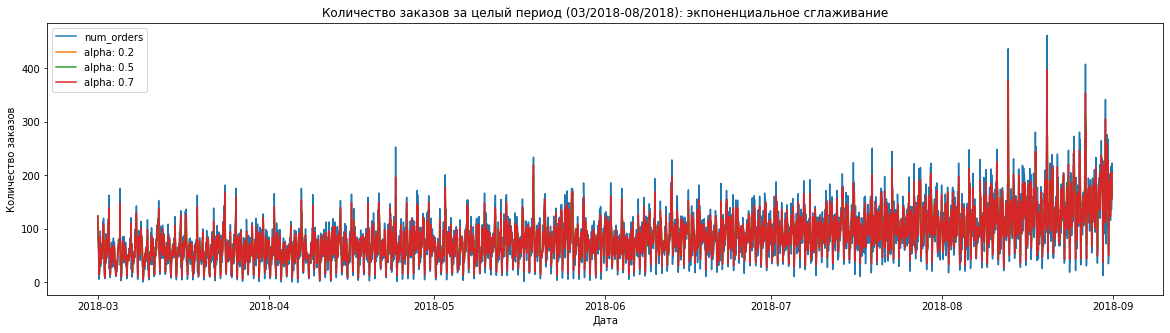

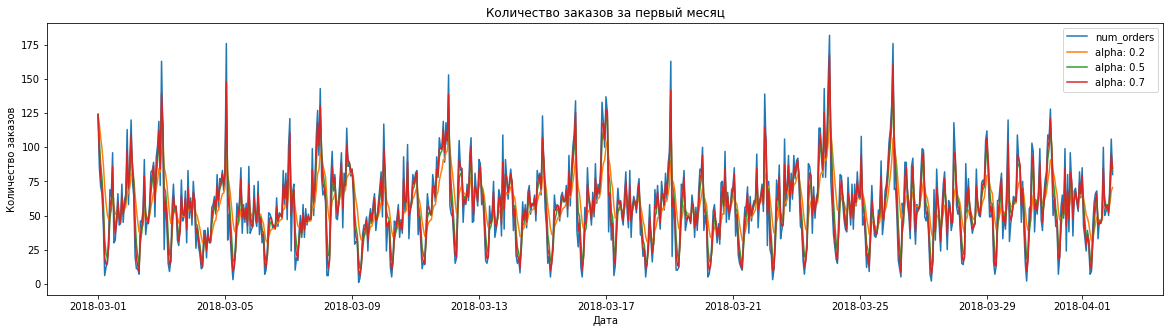

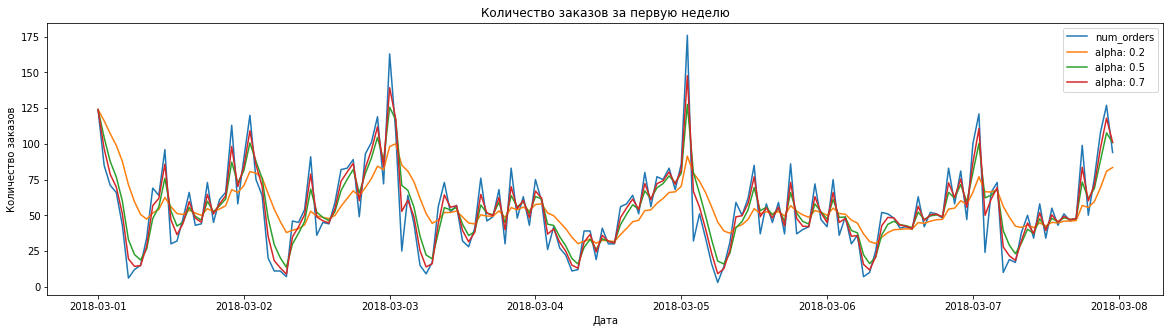

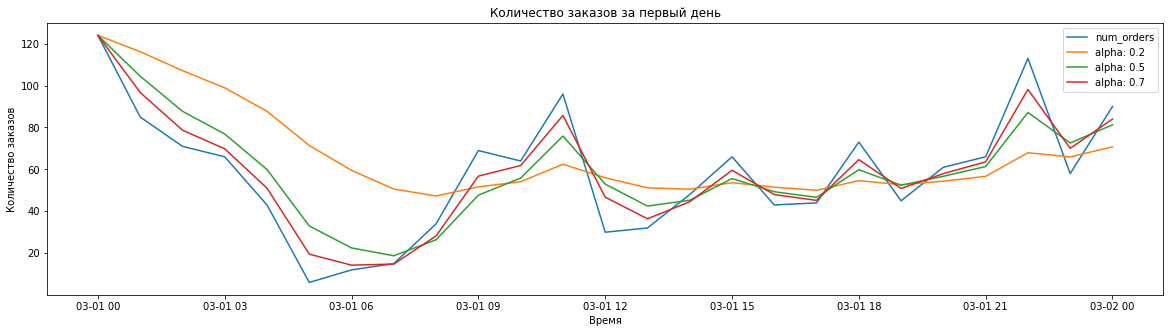

In [11]:
#Целый период

plt.figure(figsize=(20, 5))
plt.plot(taxi[['num_orders', 'single_exp_0.2', 'single_exp_0.5', 'single_exp_0.7']])
plt.title('Количество заказов за целый период (03/2018-08/2018): экпоненциальное сглаживание')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.2', 'alpha: 0.5', 'alpha: 0.7'])
plt.show()

#Один месяц
plt.figure(figsize=(20, 5))
plt.plot(taxi['2018-03-01':'2018-04-01']
         [['num_orders', 'single_exp_0.2', 'single_exp_0.5', 'single_exp_0.7']])
plt.title('Количество заказов за первый месяц')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.2', 'alpha: 0.5', 'alpha: 0.7'])
plt.show()

#Одна неделя
plt.figure(figsize=(20, 5))
plt.plot(taxi['2018-03-01':'2018-03-07']
         [['num_orders', 'single_exp_0.2', 'single_exp_0.5', 'single_exp_0.7']])
plt.title('Количество заказов за первую неделю')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.2', 'alpha: 0.5', 'alpha: 0.7'])
plt.show()

#Один день
plt.figure(figsize=(20, 5))
plt.plot(taxi['2018-03-01 00:00:00':'2018-03-02 00:00:00']
         [['num_orders', 'single_exp_0.2', 'single_exp_0.5', 'single_exp_0.7']])
plt.title('Количество заказов за первый день')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.legend(['num_orders', 'alpha: 0.2', 'alpha: 0.5', 'alpha: 0.7'])
plt.show()

*Графики с двойным экспоненциальным сглаживанием*

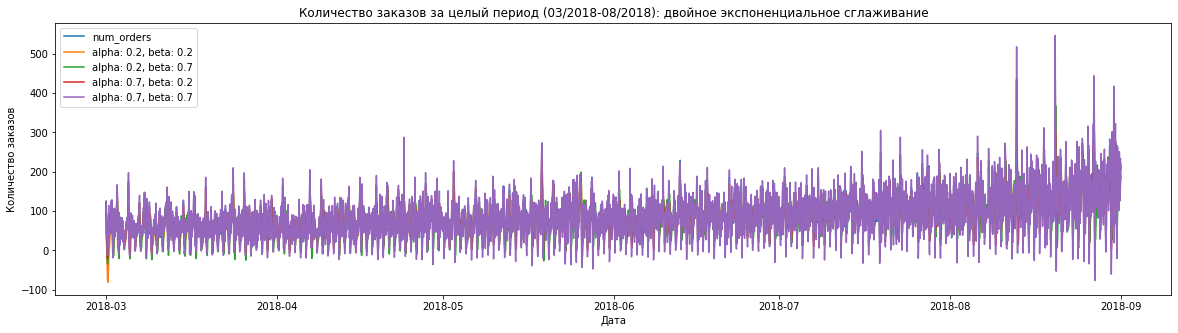

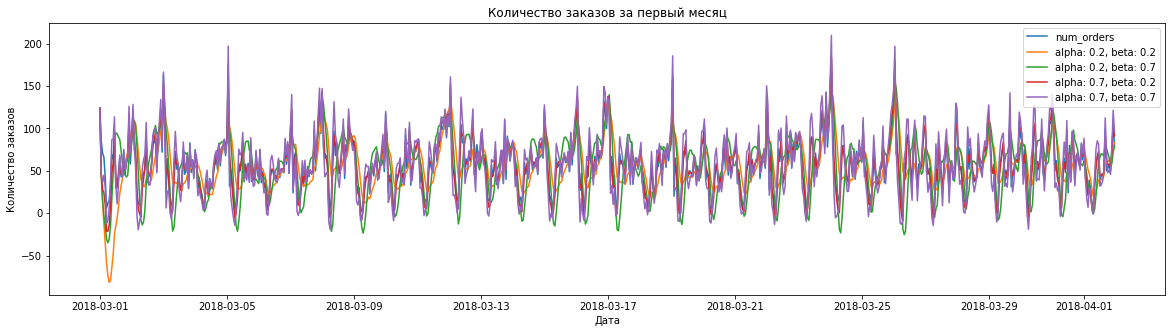

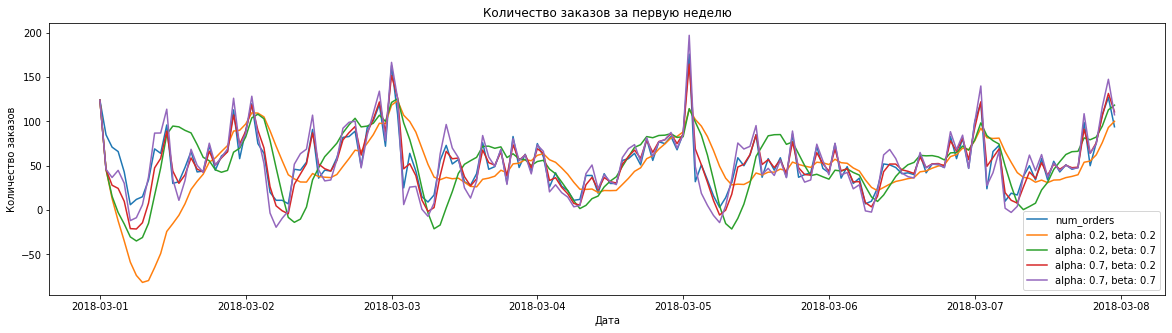

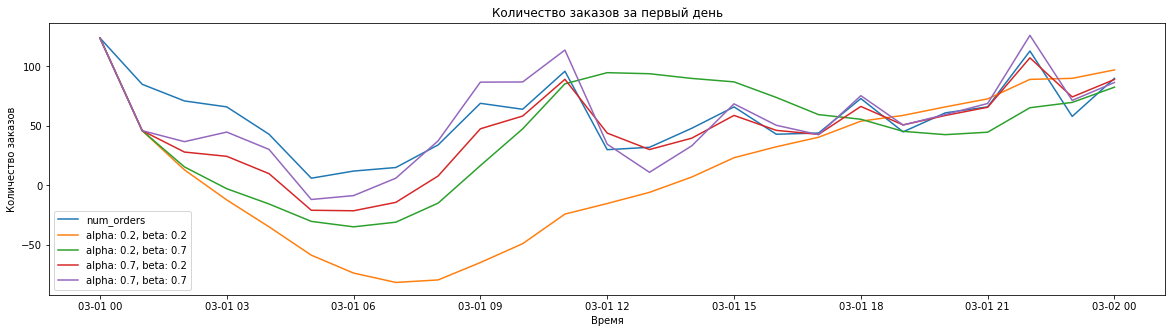

In [12]:
#Целый период

plt.figure(figsize=(20, 5))
plt.plot(taxi[['num_orders', 'double_exp_a0.2_b0.2', 'double_exp_a0.2_b0.7', 'double_exp_a0.7_b0.2', 'double_exp_a0.7_b0.7']])
plt.title('Количество заказов за целый период (03/2018-08/2018): двойное экспоненциальное сглаживание')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.2, beta: 0.2', 'alpha: 0.2, beta: 0.7', 'alpha: 0.7, beta: 0.2', 'alpha: 0.7, beta: 0.7'])
plt.show()

#Один месяц
plt.figure(figsize=(20, 5))
plt.plot(taxi['2018-03-01':'2018-04-01']
         [['num_orders', 'double_exp_a0.2_b0.2', 'double_exp_a0.2_b0.7', 'double_exp_a0.7_b0.2', 'double_exp_a0.7_b0.7']])
plt.title('Количество заказов за первый месяц')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.2, beta: 0.2', 'alpha: 0.2, beta: 0.7', 'alpha: 0.7, beta: 0.2', 'alpha: 0.7, beta: 0.7'])
plt.show()

#Одна неделя
plt.figure(figsize=(20, 5))
plt.plot(taxi['2018-03-01':'2018-03-07']
         [['num_orders', 'double_exp_a0.2_b0.2', 'double_exp_a0.2_b0.7', 'double_exp_a0.7_b0.2', 'double_exp_a0.7_b0.7']])
plt.title('Количество заказов за первую неделю')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.2, beta: 0.2', 'alpha: 0.2, beta: 0.7', 'alpha: 0.7, beta: 0.2', 'alpha: 0.7, beta: 0.7'])
plt.show()

#Один день
plt.figure(figsize=(20, 5))
plt.plot(taxi['2018-03-01 00:00:00':'2018-03-02 00:00:00']
         [['num_orders', 'double_exp_a0.2_b0.2', 'double_exp_a0.2_b0.7', 'double_exp_a0.7_b0.2', 'double_exp_a0.7_b0.7']])
plt.title('Количество заказов за первый день')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.legend(['num_orders', 'alpha: 0.2, beta: 0.2', 'alpha: 0.2, beta: 0.7', 'alpha: 0.7, beta: 0.2', 'alpha: 0.7, beta: 0.7'])
plt.show()

Первый график вообще непонятный, слишком много информации изображено на нём. Сделаю ещё два графика используя экспоненциальное сглаживание, с параметрами, которые выдали лучшую аппроксимацию исходных данных. Найду их с помощью RMSE.

In [13]:
mse_dict = {col: mse(taxi['num_orders'], taxi[col], squared=False) for col in taxi
            .drop(columns=['num_orders', 'rolling_mean_12h', 'rolling_std_12h', 'rolling_mean_6h', 
                           'rolling_std_6h', 'rolling_mean_3h', 'rolling_std_3h',]).columns}
print('RMSE значения, полученные с помощью экспоненциального сглаживания:')
display(pd.DataFrame.from_dict(mse_dict, orient='index'))


RMSE значения, полученные с помощью экспоненциального сглаживания:


,0
single_exp_0.2,29.949800
single_exp_0.5,18.372889
single_exp_0.7,11.085970
double_exp_a0.2_b0.2,33.136054
double_exp_a0.2_b0.7,37.744537
double_exp_a0.7_b0.2,10.941788
double_exp_a0.7_b0.7,17.537885


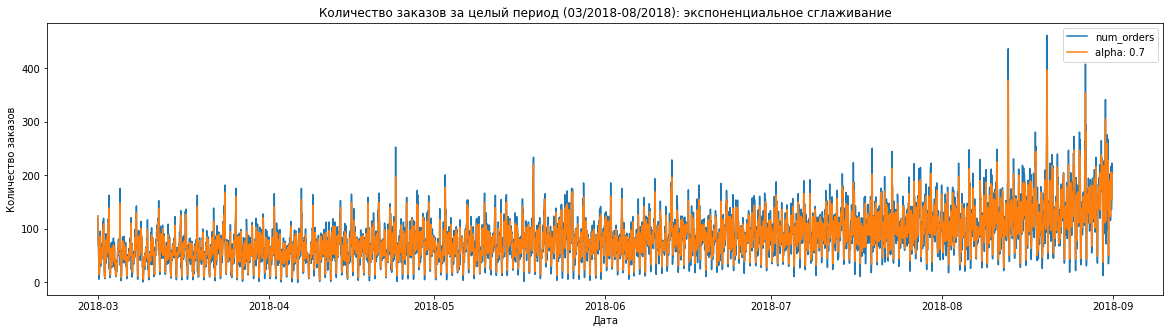

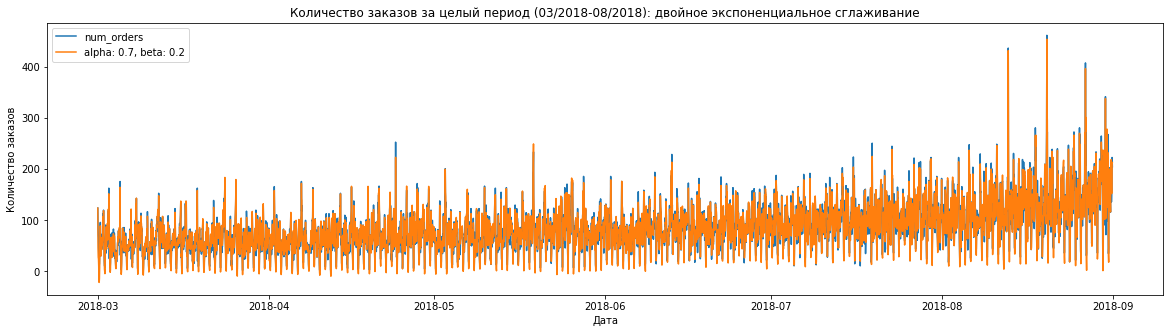

In [14]:
taxi['double_exp_a0.9_b0.9'] = double_exp_smooth(taxi['num_orders'], 0.2, 0.2)


plt.figure(figsize=(20, 5))
plt.plot(taxi[['num_orders', 'single_exp_0.7']])
plt.title('Количество заказов за целый период (03/2018-08/2018): экспоненциальное сглаживание')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.7'])
plt.show()



plt.figure(figsize=(20, 5))
plt.plot(taxi[['num_orders', 'double_exp_a0.7_b0.2']])
plt.title('Количество заказов за целый период (03/2018-08/2018): двойное экспоненциальное сглаживание')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'alpha: 0.7, beta: 0.2'])
plt.show()


Из всех этих графиков, самые полезные для понимания данных – те, где изображены данные за неделю и за месяц. На тех графиках видно, что есть какая-то сезонность в данных. Кроме этого, они мало чего добавили к моему пониманию исходных данных.

*Удадление уже не нужных столбцов*

In [15]:
taxi = pd.DataFrame(taxi['num_orders'])

#### Проверка стационарности

Для проверки стационарености ряда существует тест ADF (Augmented Dicky-Fuller) и соотвествующая функция adfuller(), что выдаёт отрицательное значение. По сути, это проверка гипотезы о том, что данный ряд имеет единичный корень и поэтому не является стационарным (H0). Если отвергается нулевая гипотеза, тогда можно считать ряд стационарным (H1; также есть нюансы с стационарностью тренда, adfuller имеет разные параметры).



In [16]:
adf_test = sm.tsa.stattools.adfuller(taxi, autolag='AIC')

print(f'Результаты теста: \n')
print(f'Результат ADF: {adf_test[0]} \n')
print(f'p-value: {adf_test[1]} \n')
print('Критические значения:')
for key, value in adf_test[4].items():
    print(f'   {key} : {value}')

Результаты теста: 

Результат ADF: -3.0689242890279558 

p-value: 0.028940051402612906 

Критические значения:
   1% : -3.431842162413052
   5% : -2.8621993540813637
   10% : -2.567120978470452


Ряд нестационарный.

Чтобы считать ряд стационарным, p-value должно быть меньше 0.05 и ADF должно быть меньше критических значение. 

В этом тесте, p-value действительно меньше 0.05, но ADF выше критических значений 5% (и 10%). Поэтому, считаю, что ряд – нестационарный.

Чтобы получить стационарный ряд, помогает разность временного ряда. Перестрою данные, а проведу тест снова.

In [17]:
taxi['difference'] = taxi - taxi.shift()
taxi = taxi.dropna(subset=['difference'])

In [18]:
adf_test = sm.tsa.stattools.adfuller(taxi['difference'], autolag='AIC')

print(f'Результаты теста: \n')
print(f'Результат ADF: {adf_test[0]} \n')
print(f'p-value: {adf_test[1]} \n')
print('Критические значения:')
for key, value in adf_test[4].items():
    print(f'   {key} : {value}')

Результаты теста: 

Результат ADF: -15.793234257410534 

p-value: 1.0958776746509151e-28 

Критические значения:
   1% : -3.431842843698785
   5% : -2.8621996550511697
   10% : -2.56712113869159


Автокорреляция и частичное автокорреляция исходных данных:


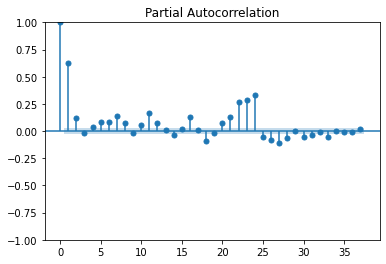

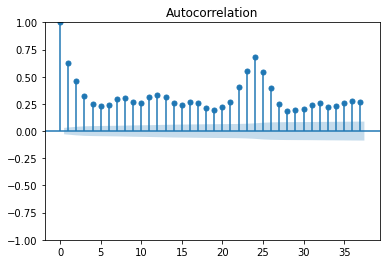

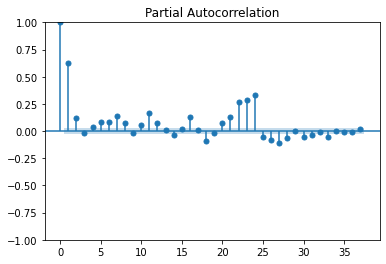

In [19]:
print("Автокорреляция и частичное автокорреляция исходных данных:")
plot_acf(taxi['num_orders'])
plot_pacf(taxi['num_orders'])



Автокорреляция и частичное автокорреляция данных разности временного ряда:


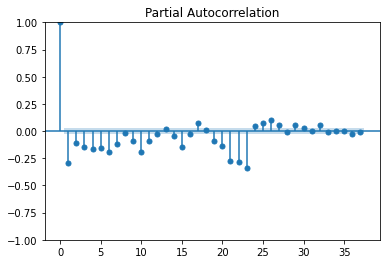

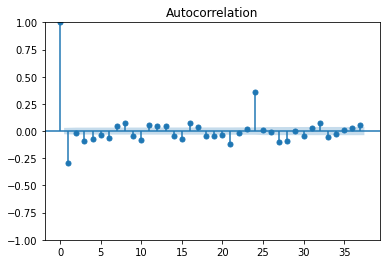

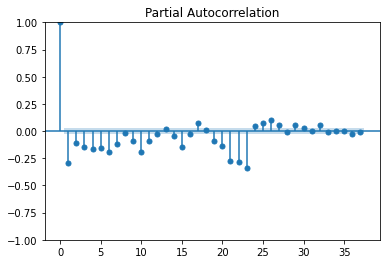

In [20]:
print("Автокорреляция и частичное автокорреляция данных разности временного ряда:")
plot_acf(taxi['difference'])
plot_pacf(taxi['difference'])

Сейчас ряд стационарный, можно приступить к применению моделей.

До этого, стоит смотреть на декомпозиции.

In [21]:
decomposed = seasonal_decompose(taxi['num_orders'])

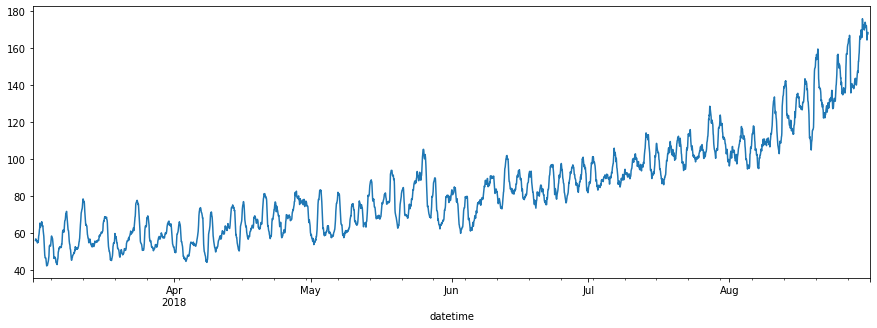

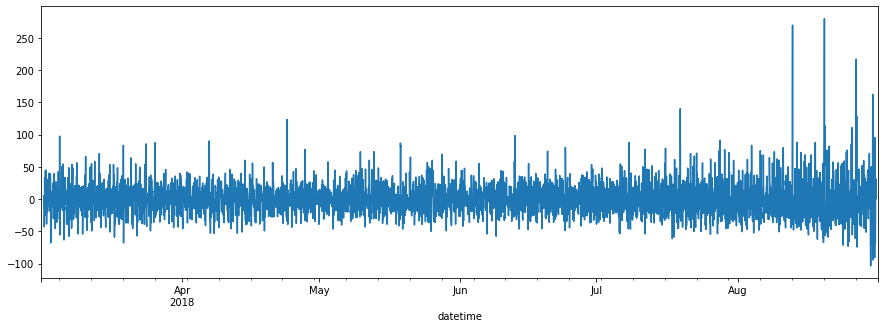

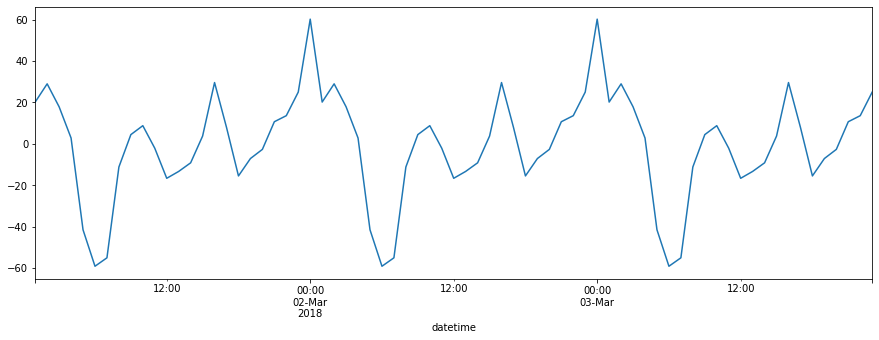

In [22]:
decomposed.trend.plot(figsize=(15,5))
plt.show()
decomposed.resid.plot(figsize=(15,5))
plt.show()
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(figsize=(15,5))
plt.show()

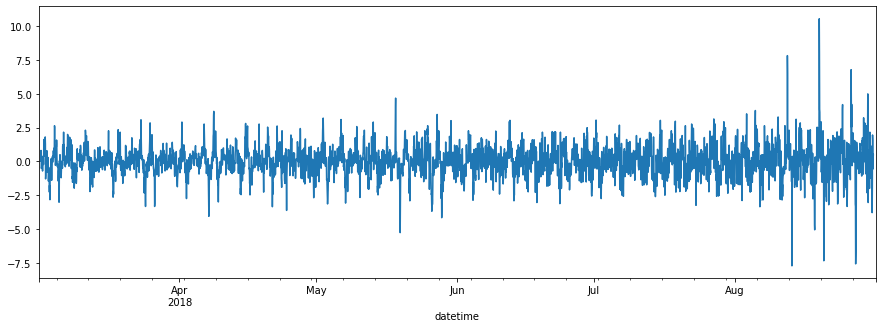

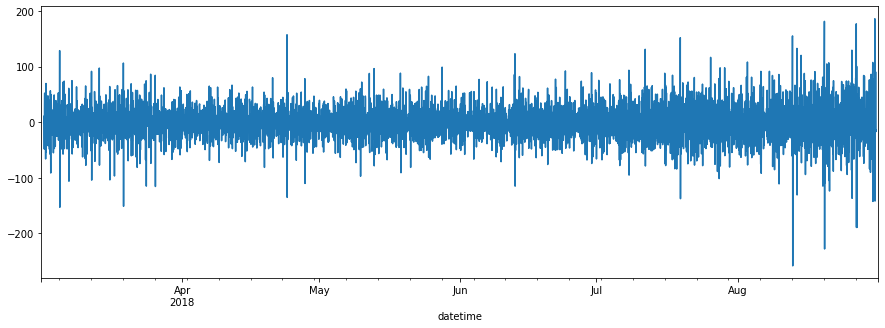

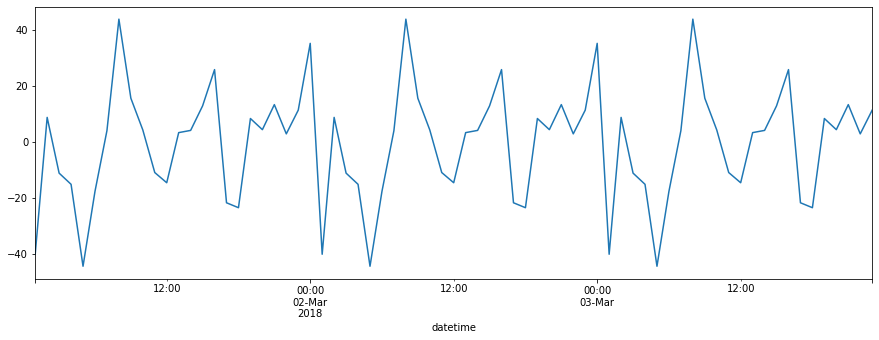

In [23]:
decomposed_shift = seasonal_decompose(taxi['difference'])
decomposed_shift.trend.plot(figsize=(15,5))
plt.show()
decomposed_shift.resid.plot(figsize=(15,5))
plt.show()
decomposed_shift.seasonal['2018-03-01':'2018-03-03'].plot(figsize=(15,5))
plt.show()

Информация о декомпозиции не так много добавила к этому проекту. Благодаря декомпозиции, стало известно:

- есть тренд вверх
    - это интересно, но нельзя доверять этому тренду, поскольку он может быть просто частью годовой сезонности
- сезонность наших данных – 24 часа
    - это информация тоже можно было видеть в графиках автокорреляции/частичной автокореляции. Однако, в них было труднее понять, а в декомпозиции эта сезонность легче видеть


## Обучение

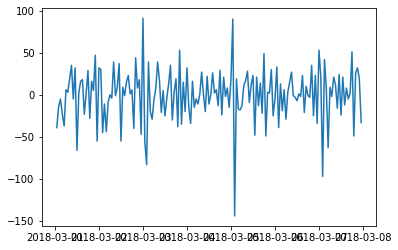

In [24]:
plt.plot(taxi['2018-03-01':'2018-03-07']['difference'])

In [25]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4415 entries, 2018-03-01 01:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4415 non-null   int64  
 1   difference  4415 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 232.5 KB


In [26]:
# train_sarima, test_sarima = train_test_split(taxi, shuffle=False, test_size=0.1)

In [27]:
# ps = range(1, 3)
# d = 1
# qs = range(1, 3)
# Ps = range(1, 3)
# D = 1
# Qs = range(1, 3)
# s = 24

# parameters_list = list(product(ps, qs, Ps, Qs))
# print(f'Длина списка параметров: {len(parameters_list)}')

# results = []
# best_aic = float('inf')


# for param in tqdm_notebook(parameters_list):
#     try: model = (sm.tsa.statespace.SARIMAX(train_sarima['difference'], 
#                                            order=(param[0], d, param[1]),
#                                            seasonal_order = (param[2], D, param[3], s))
#                   .fit(disp=-1))
#     except:
#         continue
#     aic = model.aic
#     results.append([param, model.aic])
#     if aic < best_aic:
#         best_model = model
#         best_aic = aic
#         best_param = param
        
# results_df = pd.DataFrame(results)
# display(results_df)

In [28]:
# best_model.summary()

    SARIMAX Results
    Dep. Variable:	difference	No. Observations:	3973
    Model:	SARIMAX(1, 1, 2)x(2, 1, 2, 24)	Log Likelihood	-17817.332
    Date:	Sat, 11 Jun 2022	AIC	35650.663
    Time:	20:47:47	BIC	35700.911
    Sample:	03-01-2018	HQIC	35668.487
    - 08-13-2018		

Covariance Type:	opg		

    coef	std err	z	P>|z|	[0.025	0.975]

    ar.L1	0.0596	0.014	4.269	0.000	0.032	0.087

    ma.L1	-1.8895	0.008	-243.122	0.000	-1.905	-1.874

    ma.L2	0.8898	0.008	113.452	0.000	0.874	0.905

    ar.S.L24	-1.0163	0.030	-33.732	0.000	-1.075	-0.957

    ar.S.L48	-0.1668	0.017	-10.062	0.000	-0.199	-0.134

    ma.S.L24	0.0268	0.027	0.999	0.318	-0.026	0.079

    ma.S.L48	-0.7826	0.025	-30.984	0.000	-0.832	-0.733

    sigma2	473.2362	5.976	79.187	0.000	461.523	484.949

    Ljung-Box (L1) (Q):	0.17	Jarque-Bera (JB):	6003.13
    Prob(Q):	0.68	Prob(JB):	0.00
    Heteroskedasticity (H):	1.96	Skew:	0.96
    Prob(H) (two-sided):	0.00	Kurtosis:	8.73

In [28]:
# print(len(train_sarima))
# train_w_test = pd.concat([train_sarima, test_sarima])

In [29]:
# train_w_test['forecast'] = best_model.predict(start=3972, end=4414, dynamic=True)
# rmse_sarima = mse(train_w_test.iloc[3972:4414]['difference'], train_w_test.iloc[3972:4414]['forecast'], squared=False)
# print(f'RMSE предсказаний SARIMA: {rmse_sarima}')

RMSE предсказаний SARIMA: 49.15047250806155


Получается, что SARIMA модель не могла достаточно точно предсказать количество заказов. Тут дело возможно в неправильном применении мною SARIMA, или возможно в том, что мой компьютер уже не мог обрабатывать модели когда я пытался использовать более широкий диапазон параметров p, q, P, и Q (поэтому там только range(0, 2)).

Теперь придётся использовать другой подход. Для этого создам новые столбцы в датафрейме, чтобы у моделей было что использовать.

Новые столбцы:
- day_of_week : день недели, dt.weekday
- time : час, dt.hour
- lag_x : 24 столбцов с лагами

In [29]:
taxi = taxi.drop(columns=['difference'])
# taxi['day_of_week'] = taxi.index.weekday

def add_lag(data, lags):
    df = data.copy(deep=True)
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = data['num_orders'] - data['num_orders'].shift(lag)
    return df

taxi = add_lag(taxi, 24)
taxi.head(50)

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,-14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,-5.0,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,-23.0,-28.0,-42.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,-37.0,-60.0,-65.0,-79.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6.0,-31.0,-54.0,-59.0,-73.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3.0,9.0,-28.0,-51.0,-56.0,-70.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,19.0,22.0,28.0,-9.0,-32.0,-37.0,-51.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 09:00:00,69,35.0,54.0,57.0,63.0,26.0,3.0,-2.0,-16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_for_models = taxi.dropna()
# len(df_for_models)

In [31]:
time_split = TimeSeriesSplit(n_splits=6, test_size=440)

time_split_indices = list(time_split.split(df_for_models))

In [32]:
lin_reg = LinearRegression()
rand_forest = RandomForestRegressor()
cat_boost = CatBoostRegressor(verbose=False, random_state=12345)
lgb_reg = lgb.LGBMRegressor(random_state=12345)
xgb_reg = xgb.XGBRegressor(random_state=12345)
dummy_reg = DummyRegressor()

models_list = [lin_reg, rand_forest, cat_boost, lgb_reg, xgb_reg, dummy_reg]
model_names = ['lin_reg', 'rand_forest', 'cat_boost', 'lgb_reg', 'xgb_reg', 'dummy_reg']

def models_test(features, target):
    '''
    Проверяет разные модели на базовых параметрах.
    
    Модели:
    - LinearRegression
    - RandomForestRegressor
    - CatBoostRegressor
    - LGBMRegressor
    - XGBRegressor
    - DummyRegressor
    
    Возвращает датафрейм с RMSE результатами
    '''
    rmse_dict = {'lin_reg':[], 'rand_forest':[], 'cat_boost':[], 'lgb_reg':[], 'xgb_reg':[], 'dummy_reg':[]}
    for section, i in zip(time_split_indices, range(1, len(time_split_indices)+1)):
        for model, name in zip(models_list, model_names):
            model.fit(features.iloc[section[0]], target.iloc[section[0]])
            pred = model.predict(features.iloc[section[1]])
            rmse = mse(target.iloc[section[1]], pred, squared=False)
            rmse_dict[name].append(rmse)
    rmse_df = pd.DataFrame.from_dict(rmse_dict, orient='index')
    rmse_df.columns = ['section_1', 'section_2', 'section_3', 'section_4', 'section_5', 'final_test']
    return rmse_df

In [33]:
features = df_for_models.drop(columns=['num_orders'])
target = df_for_models['num_orders']

In [ ]:
rmse_results = models_test(features, target)

In [36]:
print('''
RMSE результаты разных моделей:
    - Модели тренированные с помощью TimeSeriesSplit
''')
display(rmse_results)


RMSE результаты разных моделей:
    - Модели тренированные с помощью TimeSeriesSplit



,section_1,section_2,section_3,section_4,section_5,final_test
lin_reg,19.655272,18.229572,22.051028,29.644127,36.584524,62.620393
rand_forest,16.657003,17.072231,19.643114,25.167573,27.177381,43.515168
cat_boost,13.549636,15.142956,16.974300,20.639491,20.542279,30.479267
lgb_reg,14.187220,15.261617,17.327444,21.959594,22.412010,34.814846
xgb_reg,15.372604,15.754043,17.883888,22.270557,22.492545,33.877147
dummy_reg,39.874930,35.931590,39.221333,46.567439,58.367738,84.689792


Благодаря TimeSeriesSplit, мы видим, что RMSE увеличивается с увеличением размера тестовой выборки. Это рост в RMSE достаточно равномерен, нету неожиданных изменений в качестве предсказаний. С не-временными данными, хотелось бы видеть похожие результаты в каждой итерации кросс-валидации. Поскольку количество данных увеличивается при каждой итерации, можно считать, что результаты и полученные модели достоверные.

Уже видно, что изначальная задача – получить RMSE меньше 48 – уже выполнена. У RandomForestRegressor, CatBoostRegressor, LGBMRegressor, и XGBRegressor в последном тесте RMSE меньше 48.

Всё-таки стоит смотреть, можно ли получить результат по лучше. У CatBoostRegressor, LGBMRegressor, и XGBRegressor есть лучшие результаты. Я знаю, что из них, CatBoostRegressor работает дольше всего, поэтому попробую найти гиперпараметры для LGBMRegressor и XGBRegressor чтобы получить ещё лучшие результаты.

(Я попробовал с CatBoostRegressor тоже, но он очень долго обрабатывался, поэтому решил использовать других две.) 

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    df_for_models.drop(columns=['num_orders']), df_for_models['num_orders'], shuffle=False, test_size=0.1)

In [38]:
# def objective_lgb(trial):
    
#     params = {
#         'boosting_type' : 'gbdt',
#         'n_estimators' : trial.suggest_int('n_estimators', 50, 1000, 50),
#         'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.2),
#         'max_depth' : trial.suggest_int('max_depth', 1, 20, 2),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 50, 1000, 50),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         "subsample": trial.suggest_float("subsample", 0.3, 1.0),
#         "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 300, 10),
#         'verbose' : -1
#     }
#     lgb_mod = lgb.LGBMRegressor(**params, random_state=12345)
#     lgb_mod.fit(features_train, target_train)
#     pred = lgb_mod.predict(features_test)
#     rmse = mse(target_test, pred, squared=False)
#     return rmse

# study_lgb = optuna.create_study(direction='minimize')
# study_lgb.optimize(objective_lgb, n_trials=100)


# print("Number of finished trials: {}".format(len(study_lgb.trials)))

# print("Best trial:")
# trial_lgb = study_lgb.best_trial

# print("  Value: {}".format(trial_lgb.value))

# print("  Params: ")
# for key, value in trial_lgb.params.items():
#     print("    {}: {}".format(key, value))


# display(optuna.importance.get_param_importances(study_lgb))

Best trial:

  Value: 26.83918247473667
  
  Params: 
  
    n_estimators: 650
    learning_rate: 0.15635560834875986
    max_depth: 3
    reg_alpha: 0.00373773051196794
    reg_lambda: 2.1729273945396528e-06
    num_leaves: 350
    colsample_bytree: 0.8286546632081163
    subsample: 0.9106986794728571
    subsample_freq: 3
    min_child_samples: 20

In [39]:
#  def objective_xgb(trial):
   
#      params = {
#          'n_estimators' : trial.suggest_int('n_estimators', 5, 150),
#          'max_depth' : trial.suggest_int('max_depth', 2, 16),
#          'max_leaves' : trial.suggest_int('max_leaves', 30, 100),
#          'learning_rate' : trial.suggest_float('learning_rate', 0.1, 1),
#          'reg_alpha' : trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
#          'reg_lambda' : trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
#          'verbosity' : 0,
#          'booster' : 'gbtree'
#      }
   
#      xgb_mod = xgb.XGBRegressor(**params, random_state=12345)
#      xgb_mod.fit(features_train, target_train)
#      pred = xgb_mod.predict(features_test)
#      rmse = mse(target_test, pred, squared=False)
#      return rmse
#  study_xgb = optuna.create_study(direction='minimize')
#  study_xgb.optimize(objective_xgb, n_trials=100)
#  print("Number of finished trials: {}".format(len(study_xgb.trials)))
#  print("Best trial:")
#  trial_xgb = study_xgb.best_trial
#  print("  Value: {}".format(trial_xgb.value))
#  print("  Params: ")
#  for key, value in trial_xgb.params.items():
#      print("    {}: {}".format(key, value))
#  display(optuna.importance.get_param_importances(study_xgb))




Best trial:

  Value: 28.043415113758833
  
  Params: 
  
    n_estimators: 86
    max_depth: 2
    max_leaves: 36
    learning_rate: 0.9782028393124327
    reg_alpha: 3.2946286928623926e-08
    reg_lambda: 0.67944466608964

## Тестирование

Для финального тестирования, буду использовать TimeSeriesSplit с двумя лучшими моделами. Таким образом, получу лучшие результаты, а также перепроверю за присутствие проблемы с треинированием. 

Потом, построю графики чтобы визуализировать результаты.

In [40]:
# trial_xgb.params

In [37]:
lgb_params = {'n_estimators': 650,
              'learning_rate': 0.15635560834875986,
              'max_depth': 3,
              'reg_alpha': 0.00373773051196794,
              'reg_lambda': 2.1729273945396528e-06,
              'num_leaves': 350,
              'colsample_bytree': 0.8286546632081163,
              'subsample': 0.9106986794728571,
              'subsample_freq': 3,
              'min_child_samples': 20
             }

xgb_params = {'n_estimators': 86,
              'max_depth': 2,
              'max_leaves': 36,
              'learning_rate': 0.9782028393124327,
              'reg_alpha': 3.2946286928623926e-08,
              'reg_lambda': 0.67944466608964
             }


lgb_reg = lgb.LGBMRegressor(**lgb_params, random_state=12345)
xgb_reg = xgb.XGBRegressor(**xgb_params,random_state=12345)
dummy_reg = DummyRegressor()


models_list = [lgb_reg, xgb_reg, dummy_reg]
model_names = ['lgb_reg', 'xgb_reg', 'dummy_reg']


def final_test(features, target):
    '''
    Проверяет лучшие модели и дамми модель, используя RMSE как метрику. 
    
    Строит таблицу с RMSE и графики с предсказаниями.
    
    Модели:
    - LGBMRegressor
    - XGBRegressor
    - DummyRegressor
    
    Возвращает None.
    
    '''
    ### RMSE
    rmse_dict = {'lgb_reg':[], 'xgb_reg':[], 'dummy_reg':[]}
    for section, i in zip(time_split_indices, range(1, len(time_split_indices)+1)):
        for model, name in zip(models_list, model_names):
            model.fit(features.iloc[section[0]], target.iloc[section[0]])
            pred = model.predict(features.iloc[section[1]])
            rmse = mse(target.iloc[section[1]], pred, squared=False)
            rmse_dict[name].append(rmse)
            
    rmse_df = pd.DataFrame.from_dict(rmse_dict, orient='index')
    rmse_df.columns = ['section_1', 'section_2', 'section_3', 'section_4', 'section_5', 'final_test']
    
    ### Графики
    taxi_final = pd.DataFrame(taxi['num_orders'].copy())
    taxi_final['lgb_preds'] = np.nan
    taxi_final['xgb_preds'] = np.nan
    taxi_final['dummy_preds'] = np.nan
    
    lgb_results = []
    xgb_results = []
    dummy_results = []
    results_list = [lgb_results, xgb_results, dummy_results]
    
    for model, results in zip(models_list, results_list):
        features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)
        model.fit(features_train, target_train)
        results.append(model.predict(features_test))
    
    print(xgb_results[0])

#    taxi_final.iloc[3975:]['lgb_preds'] = lgb_results[0]
#    taxi_final.iloc[3975:]['xgb_preds'] = xgb_results[0]
#    taxi_final.iloc[3975:]['dummy_preds'] = dummy_results[0]
#
#
#    # последний месяц
#    plt.figure(figsize=(20, 5))
#    plt.plot(taxi_final['2018-08-01 00:00:00':'2018-08-31 23:00:00'])
#    plt.title('Количество заказов за последний месяц')
#    plt.ylabel('Количество заказов')
#    plt.xlabel('Дата')
#    plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
#    plt.show()
#    
#    # последний полумесяц
#    plt.figure(figsize=(20, 5))
#    plt.plot(taxi_final['2018-08-13 00:00:00':'2018-08-31 23:00:00'])
#    plt.title('Количество заказов за последний полумесяц')
#    plt.ylabel('Количество заказов')
#    plt.xlabel('Дата')
#    plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
#    plt.show()
#    
#    # последняя неделя
#    plt.figure(figsize=(20, 5))
#    plt.plot(taxi_final['2018-08-24 00:00:00':'2018-08-31 23:00:00'])
#    plt.title('Количество заказов за последнюю неделю')
#    plt.ylabel('Количество заказов')
#    plt.xlabel('Дата')
#    plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
#    plt.show()
#    
#    # последний день
#    plt.figure(figsize=(20, 5))
#    plt.plot(taxi_final['2018-08-31 00:00:00':'2018-08-31 23:00:00'])
#    plt.title('Количество заказов за последний день')
#    plt.ylabel('Количество заказов')
#    plt.xlabel('Дата')
#    plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
#    plt.show()
#    
#    display(rmse_df) 
#    taxi_final.info()


In [38]:
final_test(features, target)

[128.21257  132.25296   86.69273   82.66213   86.24954  163.85341
  86.84318   87.76511  112.50118  274.37503   64.218605 166.10698
 158.24341   37.52822   21.190186  29.029388  73.228294 111.31282
 152.8124   144.43881  110.196815  62.215992 107.77273   91.28676
  84.81111  135.0217    68.75004   79.42506   75.45443   99.08922
  60.560528 190.34189  190.34473   55.525814 185.02502   92.21517
 130.33218   78.34897   35.982388  25.29092   71.25176  117.37301
 179.97758  115.95744  102.932724  70.596375  87.83083   78.02318
 213.83548  188.84898   64.905685 131.9393   103.28689  262.84985
 144.48878   87.10813  199.73186  163.47289  177.15219  163.68918
 150.67561  114.87301   18.838326  24.230066 129.27295  169.02913
 178.5927    68.23416   89.20064   74.075165  83.07355   99.37184
 224.7453   200.88437  105.963905  84.6297    75.07713  115.59118
 147.37135  118.300354 211.9592   164.642    185.15012  135.40787
 192.2069    56.298576  34.0454    60.49783   77.3407   108.6859
 151.77872 

*Я проверял и перепроверял код чтобы понять, почему список xgb_results не переписывает столбец 'xgb_preds'; я без понятия. В своём коде не вижу никакой разницы между тем, что делал с этим списком и тем, что делал с другими (успешными). Чтобы визуализировать итоговые результаты, я скопировал значения и только так смог переписать 'xgb_preds'. Потом я снова построил графики (внизу).*

### Общий вывод


В этом проекте былы выполнены следующие шаги:

- Загрузка данных
- Подготовка данных
    - Ресэмплинг
- Анализ
    - Визуализация данных
    - Проверка стационарности
- Обучение
    - Проверка разных моделей
    - Оптимизация лучших моделей
- Тестирование

Финальное тестирование показало, что лучшая модель:

LGBMRegressor

Итоговый RMSE: 26.839

Параметры:

    'n_estimators': 650,
    'learning_rate': 0.15635560834875986,
    'max_depth': 3,
    'reg_alpha': 0.00373773051196794,
    'reg_lambda': 2.1729273945396528e-06,
    'num_leaves': 350,
    'colsample_bytree': 0.8286546632081163,
    'subsample': 0.9106986794728571,
    'subsample_freq': 3,
    'min_child_samples': 20

In [43]:
### Графики
taxi_final = pd.DataFrame(taxi['num_orders'].copy())
taxi_final['lgb_preds'] = np.nan
taxi_final['xgb_preds'] = np.nan
taxi_final['dummy_preds'] = np.nan

lgb_results = []
xgb_results = []
dummy_results = []
results_list = [lgb_results, xgb_results, dummy_results]

for model, results in zip(models_list, results_list):
    features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)
    model.fit(features_train, target_train)
    results.append(model.predict(features_test))


taxi_final.iloc[3975:]['lgb_preds'] = lgb_results[0]
taxi_final.iloc[3975:]['xgb_preds'] = xgb_results[0]
taxi_final.iloc[3975:]['dummy_preds'] = dummy_results[0]

In [44]:
# xgb_results[0]

In [45]:
taxi_final.iloc[3975:]['xgb_preds'] = [128.21257 , 132.25296 ,  86.69273 ,  82.66213 ,  86.24954 ,
       163.85341 ,  86.84318 ,  87.76511 , 112.50118 , 274.37503 ,
        64.218605, 166.10698 , 158.24341 ,  37.52822 ,  21.190186,
        29.029388,  73.228294, 111.31282 , 152.8124  , 144.43881 ,
       110.196815,  62.215992, 107.77273 ,  91.28676 ,  84.81111 ,
       135.0217  ,  68.75004 ,  79.42506 ,  75.45443 ,  99.08922 ,
        60.560528, 190.34189 , 190.34473 ,  55.525814, 185.02502 ,
        92.21517 , 130.33218 ,  78.34897 ,  35.982388,  25.29092 ,
        71.25176 , 117.37301 , 179.97758 , 115.95744 , 102.932724,
        70.596375,  87.83083 ,  78.02318 , 213.83548 , 188.84898 ,
        64.905685, 131.9393  , 103.28689 , 262.84985 , 144.48878 ,
        87.10813 , 199.73186 , 163.47289 , 177.15219 , 163.68918 ,
       150.67561 , 114.87301 ,  18.838326,  24.230066, 129.27295 ,
       169.02913 , 178.5927  ,  68.23416 ,  89.20064 ,  74.075165,
        83.07355 ,  99.37184 , 224.7453  , 200.88437 , 105.963905,
        84.6297  ,  75.07713 , 115.59118 , 147.37135 , 118.300354,
       211.9592  , 164.642   , 185.15012 , 135.40787 , 192.2069  ,
        56.298576,  34.0454  ,  60.49783 ,  77.3407  , 108.6859  ,
       151.77872 , 109.900826,  76.79837 , 101.15306 ,  99.974464,
        77.96952 , 184.03378 , 162.57481 , 111.65985 ,  81.43072 ,
        93.779106, 127.04591 , 172.49481 , 119.62125 , 239.97646 ,
       153.78065 , 273.99463 , 189.63544 , 101.21283 ,  57.324356,
        13.428218,  27.177778,  69.24779 , 211.76682 , 129.58937 ,
        82.51828 ,  76.59067 ,  49.604942,  89.31398 , 152.22673 ,
        80.75191 ,  94.74464 ,  57.887436, 104.932205,  72.22547 ,
       110.21122 ,  56.302795, 167.94685 , 172.72316 ,  73.16735 ,
       110.44308 , 180.59161 , 133.94363 ,  47.869537,  23.669542,
        74.49206 ,  57.91766 , 150.42493 , 112.22293 ,  33.64247 ,
       153.1628  , 141.88542 ,  97.01962 , 135.73845 , 100.356445,
       209.68002 ,  77.596535,  93.68239 , 101.035164,  84.51121 ,
       123.001564, 168.3985  , 182.0312  , 233.36905 , 424.62537 ,
       221.1899  , 358.37274 , 115.26784 ,  38.94439 ,  35.75566 ,
        60.20775 , 121.716286, 148.20241 , 156.74736 ,  91.50318 ,
       108.921646, 110.81216 , 292.46503 , 175.29863 ,  94.99659 ,
       107.426704, 152.75919 ,  73.49392 , 167.03221 , 217.8858  ,
       134.8733  , 154.86055 , 234.0172  , 129.56409 , 209.88474 ,
       231.83133 ,  32.378864,  37.92069 ,  23.224905,  57.72335 ,
        87.65981 , 116.45622 , 111.85787 ,  86.067406,  44.902977,
       102.58064 , 127.815475, 106.75976 , 155.86188 ,  75.906   ,
        91.03904 ,  99.55799 , 145.56265 ,  90.72026 , 162.38982 ,
       238.38847 , 104.725716, 195.36488 , 144.05286 , 114.18094 ,
        78.20588 ,  33.929554,  33.44965 ,  67.1688  , 112.18584 ,
        73.16495 ,  68.64745 ,  61.429893,  93.04547 , 111.07527 ,
        62.83697 , 181.40372 , 175.9908  ,  82.49628 , 105.070816,
        72.20301 , 108.89984 ,  81.4852  ,  50.200253, 174.6768  ,
       156.71782 , 178.1284  , 151.80417 , 101.826706,  71.160446,
        19.55914 ,  28.296055,  90.74151 , 140.78613 , 164.85548 ,
        74.868866, 119.04187 ,  90.416855,  98.08831 , 104.53835 ,
       188.31367 , 171.17075 , 136.48306 ,  76.199   , 100.83841 ,
       164.89847 , 118.778755, 165.16568 , 233.11241 , 185.01855 ,
       172.65768 ,  82.34554 ,  74.337746,  57.309135,  62.078686,
        39.045944,  70.629486, 174.5639  , 190.92455 , 150.90018 ,
        90.9542  , 152.94179 ,  96.39791 , 110.55788 , 195.07094 ,
       210.3753  , 117.02131 , 106.417076, 147.16779 , 191.02998 ,
       228.74957 , 178.0961  , 264.02533 , 182.51523 , 172.8139  ,
       196.71234 , 136.07385 ,  88.81496 ,  33.603798,  31.278034,
        71.95937 , 188.7089  , 128.36513 ,  66.238686,  91.963615,
        81.288765, 107.11475 , 137.72597 , 166.60751 , 147.27097 ,
       132.33255 ,  99.6189  ,  81.33614 , 125.59026 , 126.88836 ,
       149.95407 , 261.60788 , 130.91525 , 124.30216 , 302.05383 ,
        66.08264 ,  57.36095 ,  32.911327,  70.43488 , 120.260956,
       109.584236, 138.90694 ,  74.85085 , 115.49366 ,  94.96914 ,
       126.71194 , 106.62302 , 133.80293 , 154.17197 ,  97.06376 ,
        93.759094, 100.28883 ,  75.21979 ,  84.78663 , 199.25021 ,
       234.98912 , 202.81914 , 424.62537 , 254.48245 , 294.73096 ,
        73.4472  ,  19.026396,  23.958036, 129.65143 , 190.88052 ,
       186.5903  , 207.9752  , 140.63383 , 143.50507 ,  99.436295,
       197.6683  , 174.32782 , 174.38487 ,  86.015594, 119.98993 ,
       113.06033 , 180.90851 , 177.6073  , 160.06955 , 164.38437 ,
       121.984764,  85.93692 , 150.93678 ,  36.411926,  41.78737 ,
        49.968403,  38.91757 , 124.3253  , 184.10596 , 143.52177 ,
        97.67138 ,  98.68715 ,  77.64061 ,  97.13226 , 177.92165 ,
        87.97528 , 149.58466 ,  84.797585,  83.71553 ,  71.65682 ,
       189.70694 , 103.615135, 137.89162 , 154.4633  , 112.083534,
       164.26865 , 104.47201 , 104.97863 ,  54.88551 ,  57.451363,
        38.805187, 128.48389 , 160.90488 , 177.4872  , 138.77933 ,
       123.465866, 103.90473 , 163.41417 , 115.638306, 192.83708 ,
       125.77864 ,  74.049385, 112.87833 , 111.60446 , 116.88879 ,
       121.968765, 238.31622 , 147.61671 , 147.82011 , 218.05658 ,
       126.855034, 120.669785,  37.55076 ,  24.290428,  28.452291,
        86.77338 , 171.0377  , 197.67296 , 124.81132 , 114.52779 ,
       127.72794 , 114.010956, 117.956894, 175.84816 , 256.67874 ,
       127.63091 ,  73.242   , 158.36945 , 205.81845 , 167.83792 ,
       221.08046 , 223.48836 , 209.3857  , 278.90244 ,  94.79694 ,
       298.68713 ,  99.271515,  88.71992 ,  53.270615, 142.22263 ,
       255.64441 , 174.73158 , 167.40099 , 127.48653 , 179.92888 ,
       152.5315  ,  85.59884 , 247.9247  , 197.7556  , 167.81879 ,
       113.344666, 103.04967 , 146.67122 , 187.22906 , 193.93205 ]

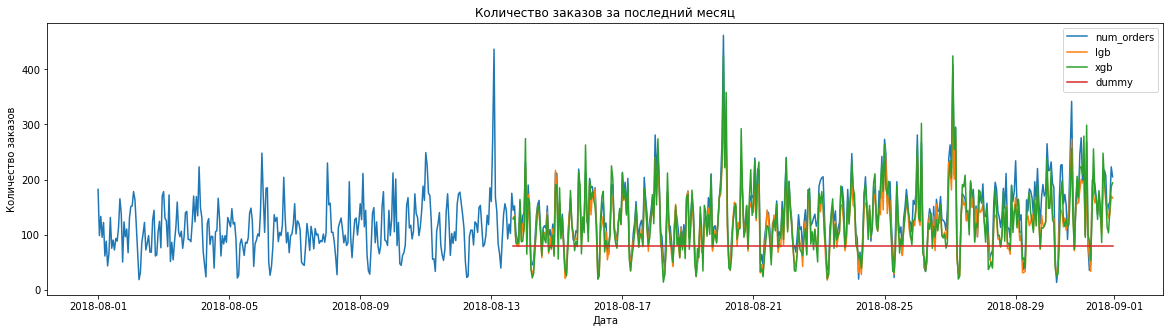

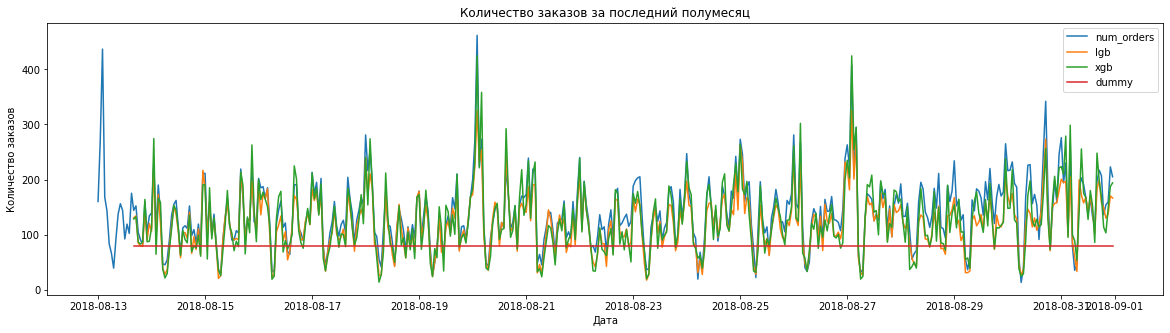

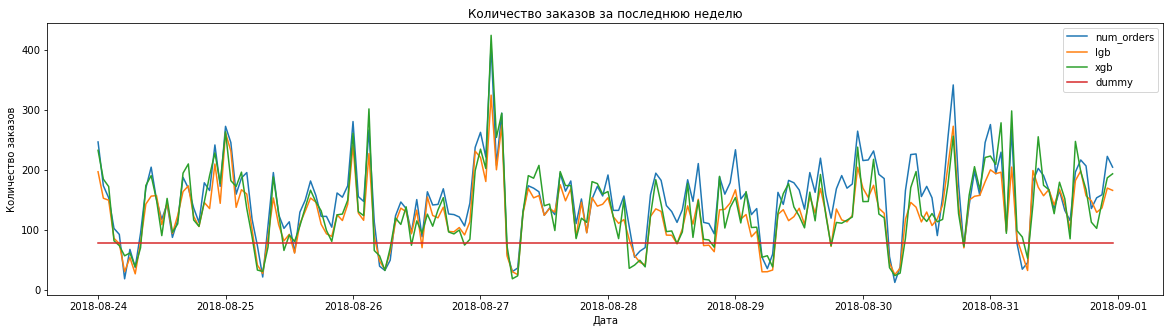

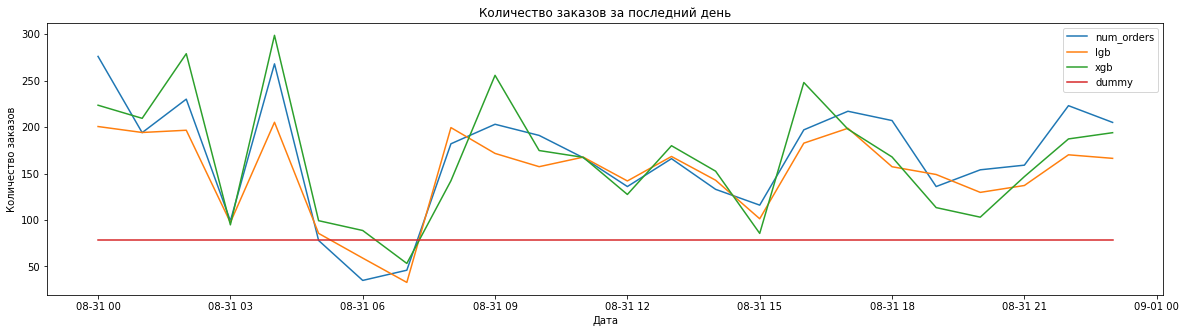

In [46]:

plt.figure(figsize=(20, 5))
plt.plot(taxi_final['2018-08-01 00:00:00':'2018-08-31 23:00:00'])
plt.title('Количество заказов за последний месяц')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
plt.show()


plt.figure(figsize=(20, 5))
plt.plot(taxi_final['2018-08-13 00:00:00':'2018-08-31 23:00:00'])
plt.title('Количество заказов за последний полумесяц')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
plt.show()


plt.figure(figsize=(20, 5))
plt.plot(taxi_final['2018-08-24 00:00:00':'2018-08-31 23:00:00'])
plt.title('Количество заказов за последнюю неделю')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
plt.show()


plt.figure(figsize=(20, 5))
plt.plot(taxi_final['2018-08-31 00:00:00':'2018-08-31 23:00:00'])
plt.title('Количество заказов за последний день')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['num_orders', 'lgb', 'xgb', 'dummy'])
plt.show()